In [1]:
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [6]:
yf.pdr_override()
df = pdr.get_data_yahoo("YM=F", start="2017-03-20", end="2023-03-31")
#df = pd.DataFrame(data = df, columns=['Open','High', 'Low','Close','Adj Close','Volume'])
if isinstance(df, pd.DataFrame):
    df.head()

[*********************100%***********************]  1 of 1 completed


In [7]:
df.to_csv("Price_Dow.csv")

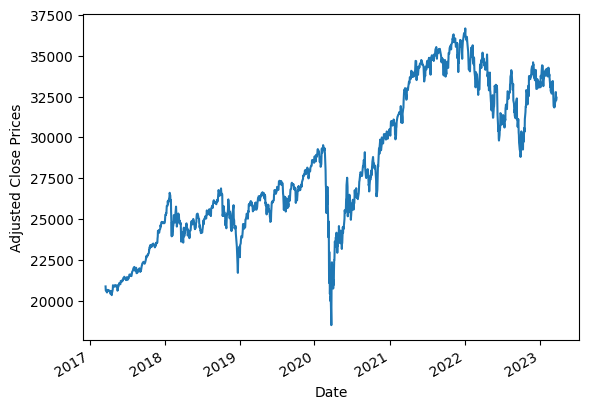

In [16]:
df['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

In [25]:
df.dropna(inplace=True)

In [26]:
x = df.iloc[:, 0:5].values
y = df.iloc[:, 4].values
x.shape
y.shape

(254,)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26,  random_state=0)

In [28]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [29]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 2, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 13, 'bootstrap': True}


In [30]:
model = RandomForestRegressor(n_estimators=500, random_state=2, min_samples_split=2, min_samples_leaf=1, max_depth=13, bootstrap=True)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)

[32170.26341406 31727.504      33774.484      33715.624
 31064.934      33413.82       31534.9        34251.508
 30116.40444141 29259.798      30377.154      33160.242
 32971.448      32971.74       31877.73       30902.276
 34329.166      33731.672      32690.704      32792.712
 33213.668      31853.63       33023.466      30304.98
 33271.86       32751.226      34665.466      32890.514
 34147.908      31692.35       33051.698      31118.372
 32258.104      33280.932      33585.122      29750.66951172
 33988.08       34841.926      34870.152      33041.46
 30689.648      34393.404      34135.738      34433.29
 32472.896      30157.40675781 34410.536      31832.754
 30488.15675781 33608.176      30761.418      33175.806
 32013.47760938 31323.248      30400.928      33827.18
 33063.304      34384.658      33970.306      34231.17
 31846.722      31001.79       35083.886      32158.23300781
 33479.484      31861.834      32810.124     ]
(67,)


In [31]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 24.1464
Mean Squared Error: 3984.1131
Root Mean Squared Error: 63.1198
(R^2) Score: 0.9981
Train Score : 99.99% and Test Score : 99.81% using Random Tree Regressor.
Accuracy: 99.92 %.


In [32]:
predictions = pd.DataFrame({"Predictions": predict}, index=pd.date_range(start=df.index[-1], periods=len(predict), freq="D"))
predictions.to_csv("Predicted-price-data.csv")
#colllects future days from predicted values
oneyear_df = pd.DataFrame(predictions[:252])
oneyear_df.to_csv("one-year-predictions.csv")
onemonth_df = pd.DataFrame(predictions[:21])
onemonth_df.to_csv("one-month-predictions.csv")
fivedays_df = pd.DataFrame(predictions[:5])
fivedays_df.to_csv("five-days-predictions.csv")

Buy price and date
   Unnamed: 0  Predictions
9  2023-03-30    29259.798
9    29259.798
Name: Predictions, dtype: float64
Sell price and date
16    34329.166
Name: Predictions, dtype: float64


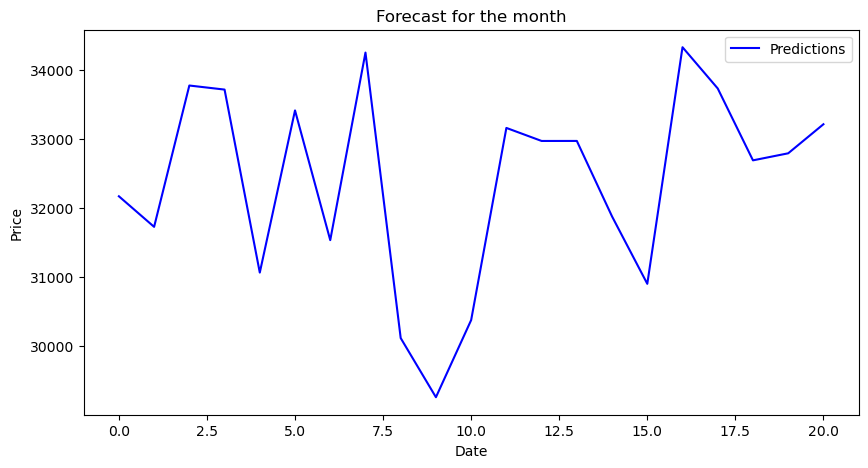

In [33]:
onemonth_df_pred = pd.read_csv("one-month-predictions.csv")
buy_price = min(onemonth_df_pred["Predictions"])
sell_price = max(onemonth_df_pred["Predictions"])
onemonth_buy = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == buy_price]
onemonth_sell = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == sell_price]
print("Buy price and date")
print(onemonth_buy)
print(onemonth_buy.loc[:, 'Predictions'])
print("Sell price and date")
print(onemonth_sell.loc[:, 'Predictions'])
onemonth_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for the month", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()